In [1]:
import os
import zarr
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


class CFG:
    particles_name = [
        "apo-ferritin",
        "beta-amylase",
        "beta-galactosidase",
        "ribosome",
        "thyroglobulin",
        "virus-like-particle",
    ]

    resolution2ratio = {
        "A": 1 / 10,
        "0": 1,
        "1": 2,
        "2": 4,
    }

    particles2cls = {
        "none": 0,
        "apo-ferritin": 1,
        "beta-amylase": 2,
        "beta-galactosidase": 3,
        "ribosome": 4,
        "thyroglobulin": 5,
        "virus-like-particle": 6,
    }
    cls2particles = {
        0: "none",
        1: "apo-ferritin",
        2: "beta-amylase",
        3: "beta-galactosidase",
        4: "ribosome",
        5: "thyroglobulin",
        6: "virus-like-particle",
    }

    particle_radius = {
        "apo-ferritin": 60,
        "beta-amylase": 65,
        "beta-galactosidase": 90,
        "ribosome": 150,
        "thyroglobulin": 130,
        "virus-like-particle": 135,
    }

    particle_weights = {
        "apo-ferritin": 1,
        "beta-amylase": 0,
        "beta-galactosidase": 2,
        "ribosome": 1,
        "thyroglobulin": 2,
        "virus-like-particle": 1,
    }

    colormap = {
        # -1の場合は透明の色
    }


def read_zarr(zarr_pth, resolution="0"):
    zarr_store = zarr.open(zarr_pth, mode="r")

    tomogram = zarr_store[resolution][:]

    return tomogram


def read_info_json(
    base_dir="../inputs/train/overlay/ExperimentRuns/",
    exp_name="TS_5_4",
    particle_name="apo-ferritin",
):

    keys = set(
        [
            "apo-ferritin",
            "beta-amylase",
            "beta-galactosidase",
            "ribosome",
            "thyroglobulin",
            "virus-like-particle",
        ]
    )

    if particle_name not in keys:
        raise ValueError(
            f"Particle name should be one of the following: {keys}. Got {particle_name}."
        )

    read_json_path = os.path.join(base_dir, exp_name, "Picks", f"{particle_name}.json")

    with open(read_json_path, "r") as f:
        particle_info = json.load(f)

    coords = []
    for point in particle_info["points"]:
        coords.append(
            [point["location"]["z"], point["location"]["y"], point["location"]["x"]]
        )

    coords = np.array(coords)

    return coords


def scale_coordinates(coords, tomogram_shape):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()

    scaled_coords[:, 0] = coords[:, 0] / coords[:, 0].max() * tomogram_shape[0]
    scaled_coords[:, 1] = coords[:, 1] / coords[:, 1].max() * tomogram_shape[1]
    scaled_coords[:, 2] = coords[:, 2] / coords[:, 2].max() * tomogram_shape[2]

    return scaled_coords


def create_dataset(
    zarr_type="ctfdeconvolved",
    base_dir="../../inputs/train/",
    exp_name="TS_5_4",
    resolution="0",
    particle_names=[],
):
    zarr_name = f"{zarr_type}.zarr"
    zarr_pth = os.path.join(
        base_dir, "static/ExperimentRuns", exp_name, "VoxelSpacing10.000/", zarr_name
    )
    tomogram = read_zarr(zarr_pth, resolution=resolution)

    particle_info = {"corrds": {}, "scaled_corrds": {}}
    for particle_name in particle_names:
        coords = read_info_json(
            os.path.join(base_dir, "overlay/ExperimentRuns/"), exp_name, particle_name
        )
        scaled_coords = scale_coordinates(coords, tomogram.shape)
        particle_info["corrds"][particle_name] = coords
        particle_info["scaled_corrds"][particle_name] = scaled_coords

    return tomogram, particle_info


def normalise_by_percentile(data, min=5, max=99):
    min = np.percentile(data, min)
    max = np.percentile(data, max)
    data = (data - min) / (max - min)
    return data, min, max


class EziiDataset(Dataset):
    def __init__(
        self,
        exp_names,
        base_dir="../../inputs/train/static",
        particles_name=CFG.particles_name,
        resolution="0",
        zarr_type="ctfdeconvolved",
    ):
        self.exp_names = exp_names
        self.base_dir = base_dir
        self.particles_name = particles_name
        self.resolution = resolution
        self.zarr_type = zarr_type

    def __getitem__(self, i):
        exp_name = self.exp_names[i]  # TS_6_6

        tomogram, particle_info = create_dataset(
            particle_names=self.particles_name,
            resolution=self.resolution,
            exp_name=exp_name,
            zarr_type=self.zarr_type,
        )

        normalized_tomogram, min, max = normalise_by_percentile(tomogram)
        apo_ferritin = particle_info["scaled_corrds"]["apo-ferritin"]
        beta_amylase = particle_info["scaled_corrds"]["beta-amylase"]
        beta_galactosidase = particle_info["scaled_corrds"]["beta-galactosidase"]
        ribosome = particle_info["scaled_corrds"]["ribosome"]
        thyroglobulin = particle_info["scaled_corrds"]["thyroglobulin"]
        virus_like_particle = particle_info["scaled_corrds"]["virus-like-particle"]

        prticle_corrds = {
            "apo-ferritin": apo_ferritin,
            "beta-amylase": beta_amylase,
            "beta-galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus-like-particle": virus_like_particle,
        }

        segmentation_map = create_segmentation_map(
            tomogram, resolution=self.resolution, particle_coords=prticle_corrds
        )

        tomogram = padding(tomogram, self.resolution)
        normalized_tomogram = padding(normalized_tomogram, self.resolution)
        segmentation_map = padding(segmentation_map, self.resolution)

        return {
            "resolution": self.resolution,
            "exp_name": exp_name,
            "tomogram": tomogram,
            "normalized_tomogram": normalized_tomogram,
            "segmentation_map": segmentation_map,
            "apo_ferritin": apo_ferritin,
            "beta_amylase": beta_amylase,
            "beta_galactosidase": beta_galactosidase,
            "ribosome": ribosome,
            "thyroglobulin": thyroglobulin,
            "virus_like_particle": virus_like_particle,
            "particle_corrds": prticle_corrds,
        }

    def __len__(self):
        return len(self.exp_names)


def padding(tomogram, resolution):
    if resolution == "0":  # 184, 630, 630 -> 184, 640, 640
        tomogram = np.pad(tomogram, ((0, 0), (5, 5), (5, 5)), mode="constant")
        return tomogram
    elif resolution == "1":  # 92, 315, 315 -> 92, 320, 320
        tomogram = np.pad(tomogram, ((0, 0), (2, 2), (2, 2)), mode="constant")
        return tomogram
    elif resolution == "2":  # 46, 158, 158 -> 46, 160, 160
        tomogram = np.pad(tomogram, ((0, 0), (1, 1), (1, 1)), mode="constant")
        return tomogram
    raise ValueError(
        f"Resolution should be one of the following: 0, 1, 2. Got {resolution}."
    )


def create_segmentation_map(tomogram, resolution, particle_coords={}):
    segmentation_map = np.zeros_like(tomogram)
    segmentation_map[:, :, :] = 0

    particle_radius = (
        CFG.particle_radius
    )  # {apo-ferritin: 60, beta-amylase: 65, beta-galactosidase: 90, ribosome: 150, thyroglobulin: 130, virus-like-particle: 135}
    particle2cls = CFG.particles2cls
    resolution_info = CFG.resolution2ratio  # {A: 1/10, 0: 1, 1: 2, 2: 4}

    r_by_particle = {}
    for particle_name, r in particle_radius.items():
        r_by_particle[particle_name] = (
            r * resolution_info["A"] / resolution_info[resolution]
        )

    for i, (paraticle_name, coords) in enumerate(particle_coords.items()):
        for z, y, x in coords:
            z, y, x = int(z), int(y), int(x)
            cls = particle2cls[paraticle_name]
            r = r_by_particle[paraticle_name]
            z_min = int(max(0, z - r))
            z_max = int(min(tomogram.shape[0], z + r))
            y_min = int(max(0, y - r))
            y_max = int(min(tomogram.shape[1], y + r))
            x_min = int(max(0, x - r))
            x_max = int(min(tomogram.shape[2], x + r))

            # x,y,zを中心に円計上にクラスを埋める
            # segmentation_map[z_min:z_max, y_min:y_max, x_min:x_max] = cls
            for z_ in range(z_min, z_max):
                for y_ in range(y_min, y_max):
                    for x_ in range(x_min, x_max):
                        if (z - z_) ** 2 + (y - y_) ** 2 + (x - x_) ** 2 < r**2:
                            segmentation_map[z_, y_, x_] = cls

    return segmentation_map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1410890

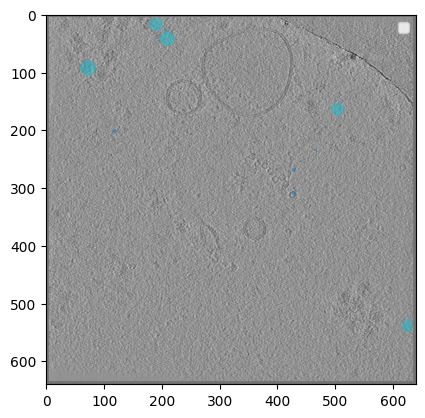

In [2]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="0",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 50
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)
plt.legend()

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

172448

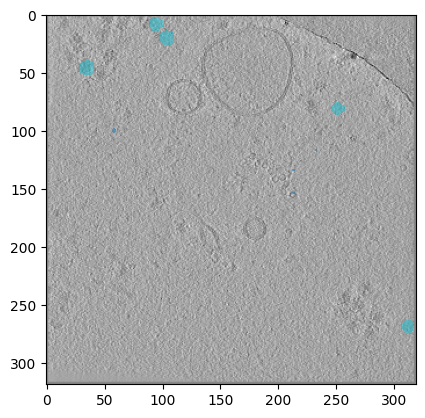

In [3]:
dataset = EziiDataset(
    exp_names=["TS_6_4"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="1",
)
normalized_tomogram = dataset[0]["normalized_tomogram"]
segmentation_map = dataset[0]["segmentation_map"]

# まずはトモグラムを表示
index = 25
plt.imshow(normalized_tomogram[index], cmap="gray")

# 重ねてクラスが存在する部分を色付け(-1の部分は透明)
target_segmentation_map = segmentation_map[index]
masked_seg = np.ma.masked_where(target_segmentation_map <= 0, target_segmentation_map)

plt.imshow(masked_seg, cmap="tab10", alpha=0.5)

# for i in range(target_segmentation_map.shape[0]):
#     for j in range(target_segmentation_map.shape[1]):
#         label = target_segmentation_map[i, j]
#         if label != -1:
#             plt.scatter(j, i, alpha=0.9, c=label)
#             cnt += 1
len(segmentation_map[segmentation_map > 0])

In [4]:
import torch
import torch.nn as nn
from icecream import ic
import segmentation_models_pytorch as smp


class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = smp.Unet(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=len(CFG.particles2cls),
        )

    def forward(self, x):

        x = self.model(x)

        return x

In [5]:
train_dataset = EziiDataset(
    exp_names=["TS_5_4", "TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    zarr_type="denoised",
)

valid_dataset = EziiDataset(
    exp_names=["TS_86_3", "TS_6_6"],
    base_dir="../../inputs/train/static",
    particles_name=CFG.particles_name,
    resolution="2",
    zarr_type="denoised",
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

  0%|          | 0/5 [00:00<?, ?it/s]


46

In [6]:
import torch.nn.functional as F


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [7]:
model = UNet_2D().to("cuda")
model.eval()


def save_images(
    train_pred_tomogram,
    train_gt_tomogram,
    valid_pred_tomogram,
    valid_gt_tomogram,
    save_dir="images",
    epoch=0,
):
    import os

    train_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "train")
    valid_save_dir = os.path.join(save_dir, f"epoch_{epoch}", "valid")
    os.makedirs(train_save_dir, exist_ok=True)
    os.makedirs(valid_save_dir, exist_ok=True)
    # 可視化
    for i in range(len(train_pred_tomogram)):
        train_pred = train_pred_tomogram[i].argmax(1).squeeze(0)
        train_gt = train_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(train_pred, cmap="tab10")
        ax.set_title("Train-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(train_gt, cmap="tab10")
        ax.set_title("Train-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(train_save_dir, f"train_{i}.png"))
        plt.close()

    for i in range(len(valid_pred_tomogram)):
        valid_pred = valid_pred_tomogram[i].argmax(1).squeeze(0)
        valid_gt = valid_gt_tomogram[i].squeeze(0)

        plt.figure(figsize=(10, 5))

        # 2つの画像を並べて表示
        ax = plt.subplot(1, 2, 1)
        ax.imshow(valid_pred, cmap="tab10")
        ax.set_title("Valid-Prediction")
        ax.axis("off")

        ax = plt.subplot(1, 2, 2)
        ax.imshow(valid_gt, cmap="tab10")
        ax.set_title("Valid-Ground Truth")
        ax.axis("off")

        plt.savefig(os.path.join(valid_save_dir, f"valid_{i}.png"))
        plt.close()


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()

best_model = None
best_loss = np.inf

for epoch in range(100):
    train_loss = []
    valid_loss = []
    train_pred_tomogram = []
    train_gt_tomogram = []
    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0]))
    for data in train_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            optimizer.zero_grad()
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]
            output = model(input_)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            train_pred_tomogram.append(output.cpu().detach().numpy())
            train_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    ############################################# valid #############################################

    valid_pred_tomogram = []
    valid_gt_tomogram = []
    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            output = model(input_)
            loss = criterion(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            valid_pred_tomogram.append(output.cpu().detach().numpy())
            valid_gt_tomogram.append(gt.cpu().detach().numpy())
    tq.close()

    if np.mean(valid_loss) < best_loss:
        best_loss = np.mean(valid_loss)
        best_model = model
        torch.save(best_model.state_dict(), "best_model.pth")

    save_images(
        train_gt_tomogram=train_gt_tomogram,
        train_pred_tomogram=train_pred_tomogram,
        valid_gt_tomogram=valid_gt_tomogram,
        valid_pred_tomogram=valid_pred_tomogram,
        save_dir="images",
        epoch=epoch,
    )

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

Valid-Epoch: 0, Loss: 1.444775350715803: 100%|██████████| 92/92 [00:03<00:00, 29.94it/s] 


Epoch: 0, Loss: 1.3189553022384644


Valid-Epoch: 1, Loss: 1.2553074644959492: 100%|██████████| 92/92 [00:03<00:00, 30.07it/s]


Epoch: 1, Loss: 1.2882682085037231


Valid-Epoch: 2, Loss: 1.2369240146616232: 100%|██████████| 92/92 [00:02<00:00, 30.78it/s]


Epoch: 2, Loss: 1.27261483669281


Valid-Epoch: 3, Loss: 1.2934674581755763: 100%|██████████| 92/92 [00:03<00:00, 29.42it/s]


Epoch: 3, Loss: 1.417038083076477


Valid-Epoch: 4, Loss: 1.3387153521180153: 100%|██████████| 92/92 [00:02<00:00, 34.69it/s]


Epoch: 4, Loss: 1.3765987157821655


Valid-Epoch: 5, Loss: 1.4057695804082828: 100%|██████████| 92/92 [00:02<00:00, 34.04it/s]


Epoch: 5, Loss: 1.4329313039779663


Valid-Epoch: 6, Loss: 1.5110236649280009: 100%|██████████| 92/92 [00:03<00:00, 28.49it/s] 


Epoch: 6, Loss: 1.5609376430511475


Valid-Epoch: 7, Loss: 1.6307239715495836: 100%|██████████| 92/92 [00:02<00:00, 33.07it/s] 


Epoch: 7, Loss: 1.4553240537643433


Valid-Epoch: 8, Loss: 1.5911474937330121: 100%|██████████| 92/92 [00:02<00:00, 32.12it/s] 


Epoch: 8, Loss: 1.6277042627334595


Valid-Epoch: 9, Loss: 1.8014108971085236: 100%|██████████| 92/92 [00:02<00:00, 33.77it/s] 


Epoch: 9, Loss: 1.7696075439453125


Valid-Epoch: 10, Loss: 1.89488066157893: 100%|██████████| 92/92 [00:02<00:00, 30.72it/s]   


Epoch: 10, Loss: 1.7967195510864258


Valid-Epoch: 11, Loss: 2.070051565280427: 100%|██████████| 92/92 [00:02<00:00, 31.49it/s]  


Epoch: 11, Loss: 1.8178460597991943


Valid-Epoch: 12, Loss: 2.171385236610861: 100%|██████████| 92/92 [00:02<00:00, 34.04it/s]  


Epoch: 12, Loss: 1.8531692028045654


Valid-Epoch: 13, Loss: 2.290146600617015: 100%|██████████| 92/92 [00:02<00:00, 33.08it/s]  


Epoch: 13, Loss: 1.8502920866012573


Valid-Epoch: 14, Loss: 2.3370332393552298: 100%|██████████| 92/92 [00:02<00:00, 33.93it/s] 


Epoch: 14, Loss: 2.0219757556915283


Valid-Epoch: 15, Loss: 2.436667383061317: 100%|██████████| 92/92 [00:02<00:00, 33.01it/s]  


Epoch: 15, Loss: 2.1069490909576416


Valid-Epoch: 16, Loss: 2.5581974374616276: 100%|██████████| 92/92 [00:02<00:00, 34.11it/s] 


Epoch: 16, Loss: 2.1874983310699463


Valid-Epoch: 17, Loss: 2.7095941474519507: 100%|██████████| 92/92 [00:02<00:00, 33.26it/s] 


Epoch: 17, Loss: 2.2446482181549072


Valid-Epoch: 18, Loss: 2.677680423260545: 100%|██████████| 92/92 [00:02<00:00, 33.12it/s]  


Epoch: 18, Loss: 2.2602949142456055


Valid-Epoch: 19, Loss: 2.802775646559894: 100%|██████████| 92/92 [00:02<00:00, 33.61it/s]  


Epoch: 19, Loss: 2.352769374847412


Valid-Epoch: 20, Loss: 2.8901730985886864: 100%|██████████| 92/92 [00:02<00:00, 34.31it/s] 


Epoch: 20, Loss: 2.3335511684417725


Valid-Epoch: 21, Loss: 3.037250714012138: 100%|██████████| 92/92 [00:02<00:00, 34.40it/s]  


Epoch: 21, Loss: 2.3225648403167725


Valid-Epoch: 22, Loss: 3.1208591051298478: 100%|██████████| 92/92 [00:02<00:00, 33.52it/s] 


Epoch: 22, Loss: 2.4845895767211914


Valid-Epoch: 23, Loss: 3.131518758387993: 100%|██████████| 92/92 [00:02<00:00, 34.09it/s]  


Epoch: 23, Loss: 2.5305511951446533


Valid-Epoch: 24, Loss: 3.172933710151878: 100%|██████████| 92/92 [00:02<00:00, 33.92it/s]  


Epoch: 24, Loss: 2.487544059753418


Valid-Epoch: 25, Loss: 3.272806100344852: 100%|██████████| 92/92 [00:03<00:00, 30.11it/s]  


Epoch: 25, Loss: 2.556668996810913


Valid-Epoch: 26, Loss: 3.274800755387253: 100%|██████████| 92/92 [00:03<00:00, 29.86it/s]  


Epoch: 26, Loss: 2.533189296722412


Valid-Epoch: 27, Loss: 3.477152965056872: 100%|██████████| 92/92 [00:03<00:00, 29.03it/s]  


Epoch: 27, Loss: 2.739612579345703


Valid-Epoch: 28, Loss: 3.4559033427124275: 100%|██████████| 92/92 [00:02<00:00, 34.52it/s] 


Epoch: 28, Loss: 2.702791452407837


Valid-Epoch: 29, Loss: 3.580444879789391: 100%|██████████| 92/92 [00:02<00:00, 31.80it/s]  


Epoch: 29, Loss: 2.8353967666625977


Valid-Epoch: 30, Loss: 3.656101157924201: 100%|██████████| 92/92 [00:02<00:00, 33.74it/s]  


Epoch: 30, Loss: 2.8398208618164062


Valid-Epoch: 31, Loss: 3.7501913169247056: 100%|██████████| 92/92 [00:02<00:00, 31.40it/s] 


Epoch: 31, Loss: 3.091627597808838


Valid-Epoch: 32, Loss: 3.7432097187366984: 100%|██████████| 92/92 [00:02<00:00, 32.27it/s]  


Epoch: 32, Loss: 3.0204076766967773


Valid-Epoch: 33, Loss: 3.792447563923855: 100%|██████████| 92/92 [00:02<00:00, 32.16it/s]  


Epoch: 33, Loss: 3.0581576824188232


Valid-Epoch: 34, Loss: 3.701093094949813: 100%|██████████| 92/92 [00:02<00:00, 31.53it/s]  


Epoch: 34, Loss: 2.978795051574707


Valid-Epoch: 35, Loss: 3.8850061443391377: 100%|██████████| 92/92 [00:03<00:00, 30.41it/s] 


Epoch: 35, Loss: 3.02123761177063


Valid-Epoch: 36, Loss: 3.965068257899712: 100%|██████████| 92/92 [00:02<00:00, 32.91it/s] 


Epoch: 36, Loss: 2.972683906555176


Valid-Epoch: 37, Loss: 4.151181936514584: 100%|██████████| 92/92 [00:02<00:00, 31.88it/s]  


Epoch: 37, Loss: 3.1632442474365234


Valid-Epoch: 38, Loss: 4.0699230459184665: 100%|██████████| 92/92 [00:02<00:00, 31.12it/s] 


Epoch: 38, Loss: 3.2386083602905273


Valid-Epoch: 39, Loss: 4.112914143484491: 100%|██████████| 92/92 [00:02<00:00, 33.74it/s]  


Epoch: 39, Loss: 3.2876458168029785


Valid-Epoch: 40, Loss: 4.295998726495663: 100%|██████████| 92/92 [00:03<00:00, 26.49it/s]  


Epoch: 40, Loss: 3.3968355655670166


Valid-Epoch: 41, Loss: 4.3939166958545055: 100%|██████████| 92/92 [00:02<00:00, 31.77it/s] 


Epoch: 41, Loss: 3.343435049057007


Valid-Epoch: 42, Loss: 4.394510842811661: 100%|██████████| 92/92 [00:03<00:00, 25.49it/s]   


Epoch: 42, Loss: 3.451387405395508


Valid-Epoch: 43, Loss: 4.30658136884196: 100%|██████████| 92/92 [00:03<00:00, 28.44it/s]   


Epoch: 43, Loss: 3.487715244293213


Valid-Epoch: 44, Loss: 4.461235551047139: 100%|██████████| 92/92 [00:03<00:00, 25.25it/s]   


Epoch: 44, Loss: 3.535494565963745


Valid-Epoch: 45, Loss: 4.409554048352773: 100%|██████████| 92/92 [00:03<00:00, 28.65it/s]  


Epoch: 45, Loss: 3.672130584716797


Valid-Epoch: 46, Loss: 4.3217110143286055: 100%|██████████| 92/92 [00:03<00:00, 29.33it/s] 


Epoch: 46, Loss: 3.559481382369995


Valid-Epoch: 47, Loss: 4.647830354798909: 100%|██████████| 92/92 [00:02<00:00, 31.64it/s]  


Epoch: 47, Loss: 3.724703073501587


Valid-Epoch: 48, Loss: 4.572484460261995: 100%|██████████| 92/92 [00:02<00:00, 30.81it/s]   


Epoch: 48, Loss: 3.7033469676971436


Valid-Epoch: 49, Loss: 4.441277659488032: 100%|██████████| 92/92 [00:02<00:00, 31.55it/s] 


Epoch: 49, Loss: 3.569514036178589


Valid-Epoch: 50, Loss: 4.608584101382724: 100%|██████████| 92/92 [00:03<00:00, 28.24it/s]  


Epoch: 50, Loss: 3.525825023651123


Valid-Epoch: 51, Loss: 4.625634261098204: 100%|██████████| 92/92 [00:03<00:00, 26.50it/s]   


Epoch: 51, Loss: 3.746929407119751


Valid-Epoch: 52, Loss: 4.748659644407503: 100%|██████████| 92/92 [00:02<00:00, 31.08it/s]  


Epoch: 52, Loss: 4.041445255279541


Valid-Epoch: 53, Loss: 4.7622864897788055: 100%|██████████| 92/92 [00:03<00:00, 28.75it/s] 


Epoch: 53, Loss: 3.874143362045288


Valid-Epoch: 54, Loss: 4.645512619273454: 100%|██████████| 92/92 [00:03<00:00, 29.44it/s]  


Epoch: 54, Loss: 3.49113130569458


Valid-Epoch: 55, Loss: 4.8762115210183365: 100%|██████████| 92/92 [00:03<00:00, 29.33it/s] 


Epoch: 55, Loss: 3.6478137969970703


Valid-Epoch: 56, Loss: 4.876063540256481: 100%|██████████| 92/92 [00:04<00:00, 22.90it/s]   


Epoch: 56, Loss: 3.775383472442627


Valid-Epoch: 57, Loss: 4.942673540424869: 100%|██████████| 92/92 [00:03<00:00, 24.10it/s]   


Epoch: 57, Loss: 3.9986345767974854


Valid-Epoch: 58, Loss: 4.966977700783426: 100%|██████████| 92/92 [00:03<00:00, 26.66it/s]  


Epoch: 58, Loss: 3.8621532917022705


Valid-Epoch: 59, Loss: 4.993926827537665: 100%|██████████| 92/92 [00:05<00:00, 16.94it/s]   


Epoch: 59, Loss: 3.985006332397461


Valid-Epoch: 60, Loss: 5.042233944422586: 100%|██████████| 92/92 [00:07<00:00, 13.05it/s]   


Epoch: 60, Loss: 4.055227279663086


Valid-Epoch: 61, Loss: 5.043040258111432: 100%|██████████| 92/92 [00:07<00:00, 12.66it/s]  


Epoch: 61, Loss: 3.9953017234802246


Valid-Epoch: 62, Loss: 5.075126977356495: 100%|██████████| 92/92 [00:06<00:00, 14.40it/s]  


Epoch: 62, Loss: 3.902134656906128


Valid-Epoch: 63, Loss: 5.10955962969962: 100%|██████████| 92/92 [00:03<00:00, 23.15it/s]    


Epoch: 63, Loss: 3.9062273502349854


Valid-Epoch: 64, Loss: 5.113403497048674: 100%|██████████| 92/92 [00:03<00:00, 28.02it/s]   


Epoch: 64, Loss: 4.073172569274902


Valid-Epoch: 65, Loss: 5.256551264983895: 100%|██████████| 92/92 [00:05<00:00, 16.95it/s]   


Epoch: 65, Loss: 4.249569892883301


Valid-Epoch: 66, Loss: 5.167661291268735: 100%|██████████| 92/92 [00:05<00:00, 17.18it/s]  


Epoch: 66, Loss: 4.169698715209961


Valid-Epoch: 67, Loss: 5.199924404601283: 100%|██████████| 92/92 [00:05<00:00, 17.24it/s]  


Epoch: 67, Loss: 3.9939403533935547


Valid-Epoch: 68, Loss: 5.386558001682557: 100%|██████████| 92/92 [00:04<00:00, 18.44it/s]   


Epoch: 68, Loss: 4.043800354003906


Valid-Epoch: 69, Loss: 5.36797819709666: 100%|██████████| 92/92 [00:03<00:00, 26.99it/s]    


Epoch: 69, Loss: 4.164277076721191


Valid-Epoch: 70, Loss: 5.435010297719956: 100%|██████████| 92/92 [00:03<00:00, 28.74it/s]  


Epoch: 70, Loss: 4.098642826080322


Valid-Epoch: 71, Loss: 5.450378336404633: 100%|██████████| 92/92 [00:03<00:00, 24.76it/s]   


Epoch: 71, Loss: 4.095546722412109


Valid-Epoch: 72, Loss: 5.381848226240634: 100%|██████████| 92/92 [00:05<00:00, 17.56it/s]  


Epoch: 72, Loss: 3.9705278873443604


Valid-Epoch: 73, Loss: 5.549764151226871: 100%|██████████| 92/92 [00:03<00:00, 29.27it/s]   


Epoch: 73, Loss: 4.404735088348389


Valid-Epoch: 74, Loss: 5.4129413067282215: 100%|██████████| 92/92 [00:05<00:00, 17.01it/s]  


Epoch: 74, Loss: 4.292612075805664


Valid-Epoch: 75, Loss: 5.582461488180106: 100%|██████████| 92/92 [00:03<00:00, 27.36it/s]   


Epoch: 75, Loss: 4.274809837341309


Valid-Epoch: 76, Loss: 5.505130156224249: 100%|██████████| 92/92 [00:03<00:00, 23.42it/s]   


Epoch: 76, Loss: 4.101229667663574


Valid-Epoch: 77, Loss: 5.668076908071627: 100%|██████████| 92/92 [00:03<00:00, 24.63it/s]   


Epoch: 77, Loss: 4.254863262176514


Valid-Epoch: 78, Loss: 5.7015018170578005: 100%|██████████| 92/92 [00:05<00:00, 16.90it/s] 


Epoch: 78, Loss: 4.176093578338623


Valid-Epoch: 79, Loss: 5.733345231979595: 100%|██████████| 92/92 [00:03<00:00, 24.67it/s]   


Epoch: 79, Loss: 4.3262553215026855


Valid-Epoch: 80, Loss: 5.74893424431186: 100%|██████████| 92/92 [00:05<00:00, 17.19it/s]   


Epoch: 80, Loss: 4.4431681632995605


Valid-Epoch: 81, Loss: 5.580062213394305: 100%|██████████| 92/92 [00:03<00:00, 28.85it/s]  


Epoch: 81, Loss: 4.187461853027344


Valid-Epoch: 82, Loss: 5.908764789335217: 100%|██████████| 92/92 [00:03<00:00, 28.05it/s]   


Epoch: 82, Loss: 4.719371318817139


Valid-Epoch: 83, Loss: 5.80308613543014: 100%|██████████| 92/92 [00:03<00:00, 29.16it/s]    


Epoch: 83, Loss: 4.4018144607543945


Valid-Epoch: 84, Loss: 5.846000145893018: 100%|██████████| 92/92 [00:04<00:00, 21.11it/s]  


Epoch: 84, Loss: 4.5912981033325195


Valid-Epoch: 85, Loss: 5.820607888122575: 100%|██████████| 92/92 [00:05<00:00, 16.61it/s]   


Epoch: 85, Loss: 4.930063247680664


Valid-Epoch: 86, Loss: 5.561240361279646: 100%|██████████| 92/92 [00:05<00:00, 17.10it/s]  


Epoch: 86, Loss: 4.654534339904785


Valid-Epoch: 87, Loss: 5.804426469728756: 100%|██████████| 92/92 [00:05<00:00, 17.68it/s]   


Epoch: 87, Loss: 4.683891773223877


Valid-Epoch: 88, Loss: 5.822329707275735: 100%|██████████| 92/92 [00:05<00:00, 17.53it/s]   


Epoch: 88, Loss: 4.726210117340088


Valid-Epoch: 89, Loss: 5.86605493461779: 100%|██████████| 92/92 [00:04<00:00, 19.42it/s]    


Epoch: 89, Loss: 4.457895755767822


Valid-Epoch: 90, Loss: 5.8411709202742: 100%|██████████| 92/92 [00:03<00:00, 28.87it/s]     


Epoch: 90, Loss: 4.514444351196289


Valid-Epoch: 91, Loss: 6.189337729022119: 100%|██████████| 92/92 [00:03<00:00, 27.48it/s]   


Epoch: 91, Loss: 4.783965110778809


Valid-Epoch: 92, Loss: 6.238796818347866: 100%|██████████| 92/92 [00:03<00:00, 25.50it/s]   


Epoch: 92, Loss: 4.915398597717285


Valid-Epoch: 93, Loss: 6.2669853783356855: 100%|██████████| 92/92 [00:05<00:00, 16.86it/s]  


Epoch: 93, Loss: 4.978388786315918


Valid-Epoch: 94, Loss: 6.066342812279522: 100%|██████████| 92/92 [00:05<00:00, 17.11it/s]  


Epoch: 94, Loss: 4.873481750488281


Valid-Epoch: 95, Loss: 6.163773254397751: 100%|██████████| 92/92 [00:03<00:00, 23.73it/s]  


Epoch: 95, Loss: 5.081608772277832


Valid-Epoch: 96, Loss: 6.159252529460228: 100%|██████████| 92/92 [00:03<00:00, 28.46it/s]   


Epoch: 96, Loss: 5.242913246154785


Valid-Epoch: 97, Loss: 6.286844288715182: 100%|██████████| 92/92 [00:03<00:00, 27.62it/s]   


Epoch: 97, Loss: 5.081084728240967


Valid-Epoch: 98, Loss: 6.293908432375326: 100%|██████████| 92/92 [00:03<00:00, 28.55it/s]   


Epoch: 98, Loss: 4.9775919914245605


Valid-Epoch: 99, Loss: 6.249133277908423: 100%|██████████| 92/92 [00:02<00:00, 30.71it/s]  


Epoch: 99, Loss: 4.923227310180664


In [8]:
normalized_tomogram.shape, segmentation_map.shape

((46, 160, 160), torch.Size([1, 46, 160, 160]))

In [9]:
model = UNet_2D().to("cuda")
model.load_state_dict(torch.load("best_model.pth"))
criterion = nn.CrossEntropyLoss(
    # weight=torch.tensor([1e-4, 1, 0, 2, 1, 2, 1]).to("cuda")
)

pred_tomogram = []
gt_tomogram = []

valid_loss = []

model.eval()
tq = tqdm(valid_loader)
for data in valid_loader:
    tomogram = data["normalized_tomogram"].to("cuda")
    segmentation_map = data["segmentation_map"].to("cuda").long()

    for i in range(tomogram.shape[1]):
        input_ = tomogram[:, i].unsqueeze(0)
        gt = segmentation_map[:, i]

        output = model(input_)
        loss = criterion(output, gt)

        valid_loss.append(loss.item())
        tq.set_description(f"Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
        tq.update(1)

        pred_tomogram.append(output.cpu().detach().numpy())
        gt_tomogram.append(gt.cpu().detach().numpy())
tq.close()

Epoch: 99, Loss: 0.6013858221147371: : 92it [00:04, 22.17it/s]                    


In [10]:
len(pred_tomogram), len(gt_tomogram)

(92, 92)

In [11]:
pred_tomogram[0].argmax(1).shape

(1, 160, 160)

In [12]:
pred_tomogram[0].argmax(1)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 4]]])

IndexError: list index out of range

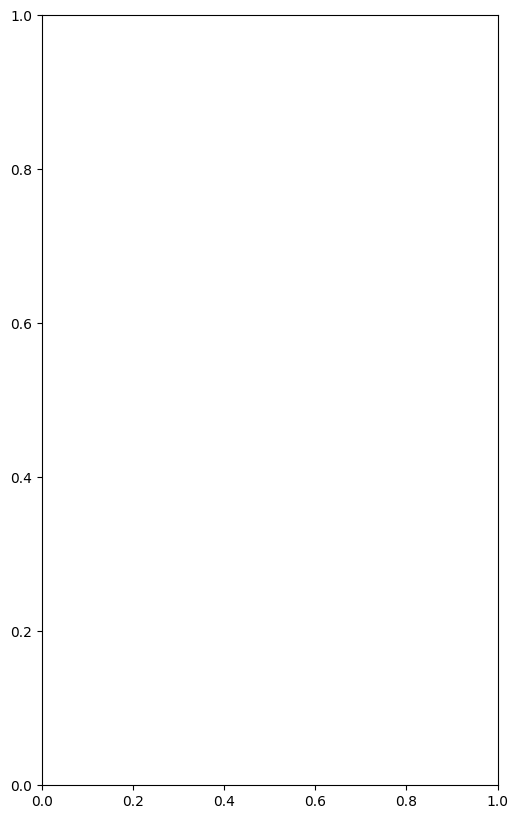

: 

In [13]:
# 可視化
index = 120

# 2つの画像を並べて表示
# plt.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
plt.figure(figsize=(20, 10))

# 2つの画像を並べて表示
ax = plt.subplot(1, 3, 1)
ax.imshow(pred_tomogram[index].argmax(1).squeeze(0), cmap="tab10")
ax.set_title("Prediction")
ax.axis("off")

ax = plt.subplot(1, 3, 2)
ax.imshow(gt_tomogram[index].squeeze(0), cmap="tab10")
ax.set_title("Ground Truth")
ax.axis("off")

ax = plt.subplot(1, 3, 3)
ax.imshow(normalized_tomogram[index], cmap="gray")
ax.set_title("Ground Truth")
ax.axis("off")

In [ ]:
normalized_tomogram[index]

In [ ]:
gt_tomogram[index].squeeze(0).shape

In [ ]:
pred_tomogram[index].argmax(1).shape